# Overview

### Target 
1. Get setup right

### Result 
1. Parameters: ~400,000
2. Best Training Accuracy: 99.60
3. Best Test Accuracy: 99.14

### Analysis 
1. Extremely heavy model for such a problem


# Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [ ]:
import matplotlib.pyplot as plt

# Data Transformations


In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
SEED = 1

cuda = torch.cuda.is_available()

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Model


In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()

    # Convolution Block 1
    self.convblock1 = nn.Sequential(
        nn.Conv2d(in_channels=1,out_channels=16,kernel_size=(3,3),padding = 0, bias = False),
        nn.ReLU(),
    )

    # Convolution Block 2
    self.convblock2 = nn.Sequential(
        nn.Conv2d(in_channels=16,out_channels=32,kernel_size=(3,3),padding = 0, bias = False),
        nn.ReLU(),
    )

    self.pool1 = nn.Sequential(
        nn.MaxPool2d(2, 2)
    )

    # Convolution Block 3
    self.convblock3 = nn.Sequential(
        nn.Conv2d(in_channels=32,out_channels=64,kernel_size=(3,3),padding = 0, bias = False),
        nn.ReLU(),
    )

    # Convolution Block 4
    self.convblock4 = nn.Sequential(
        nn.Conv2d(in_channels=64,out_channels=128,kernel_size=(3,3),padding = 0, bias = False),
        nn.ReLU(),
    )

    # Convolution Block 5
    self.convblock5 = nn.Sequential(
        nn.Conv2d(in_channels=128,out_channels=256,kernel_size=(3,3),padding = 0, bias = False),
        nn.ReLU(),
    )

    # Global average pooling layer
    self.gap = nn.Sequential(
        nn.AvgPool2d(kernel_size=6),
        nn.Conv2d(in_channels=256,out_channels=10,kernel_size=(1,1),padding = 0, bias = False)
    )
  
  def forward(self, x):

    x = self.convblock1(x)
    x = self.convblock2(x)
    x = self.pool1(x)

    x = self.convblock3(x)
    x = self.convblock4(x)    
    x = self.convblock5(x)
    
    x = self.gap(x)
    x = x.view(-1,10)
    
    return F.log_softmax(x,dim = -1)


# Model Parameters

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
            Conv2d-3           [-1, 32, 24, 24]           4,608
              ReLU-4           [-1, 32, 24, 24]               0
         MaxPool2d-5           [-1, 32, 12, 12]               0
            Conv2d-6           [-1, 64, 10, 10]          18,432
              ReLU-7           [-1, 64, 10, 10]               0
            Conv2d-8            [-1, 128, 8, 8]          73,728
              ReLU-9            [-1, 128, 8, 8]               0
           Conv2d-10            [-1, 256, 6, 6]         294,912
             ReLU-11            [-1, 256, 6, 6]               0
        AvgPool2d-12            [-1, 256, 1, 1]               0
           Conv2d-13             [-1, 10, 1, 1]           2,560
Total params: 394,384
Trainable pa

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


# Training and Testing

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
  
  train_losses.append(loss)
  train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.17616693675518036 Batch_id=468 Accuracy=51.43: 100%|██████████| 469/469 [00:20<00:00, 22.94it/s]



Test set: Average loss: 0.2454, Accuracy: 9276/10000 (92.76%)

EPOCH: 1


Loss=0.1484742909669876 Batch_id=468 Accuracy=95.04: 100%|██████████| 469/469 [00:19<00:00, 23.57it/s]



Test set: Average loss: 0.0899, Accuracy: 9729/10000 (97.29%)

EPOCH: 2


Loss=0.07473784685134888 Batch_id=468 Accuracy=97.28: 100%|██████████| 469/469 [00:19<00:00, 23.57it/s]



Test set: Average loss: 0.0663, Accuracy: 9809/10000 (98.09%)

EPOCH: 3


Loss=0.11043175309896469 Batch_id=468 Accuracy=97.92: 100%|██████████| 469/469 [00:20<00:00, 23.34it/s]



Test set: Average loss: 0.0471, Accuracy: 9857/10000 (98.57%)

EPOCH: 4


Loss=0.0593770332634449 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:20<00:00, 23.35it/s]



Test set: Average loss: 0.0403, Accuracy: 9866/10000 (98.66%)

EPOCH: 5


Loss=0.04084434732794762 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:20<00:00, 23.31it/s]



Test set: Average loss: 0.0372, Accuracy: 9885/10000 (98.85%)

EPOCH: 6


Loss=0.015704816207289696 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:20<00:00, 23.16it/s]



Test set: Average loss: 0.0431, Accuracy: 9863/10000 (98.63%)

EPOCH: 7


Loss=0.017987564206123352 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:20<00:00, 23.23it/s]



Test set: Average loss: 0.0316, Accuracy: 9899/10000 (98.99%)

EPOCH: 8


Loss=0.020139576867222786 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:20<00:00, 23.04it/s]



Test set: Average loss: 0.0332, Accuracy: 9899/10000 (98.99%)

EPOCH: 9


Loss=0.10252261906862259 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:20<00:00, 23.43it/s]



Test set: Average loss: 0.0396, Accuracy: 9878/10000 (98.78%)

EPOCH: 10


Loss=0.014387194067239761 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:20<00:00, 23.14it/s]



Test set: Average loss: 0.0306, Accuracy: 9898/10000 (98.98%)

EPOCH: 11


Loss=0.015813075006008148 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:20<00:00, 23.33it/s]



Test set: Average loss: 0.0275, Accuracy: 9907/10000 (99.07%)

EPOCH: 12


Loss=0.030077790841460228 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:20<00:00, 23.04it/s]



Test set: Average loss: 0.0343, Accuracy: 9904/10000 (99.04%)

EPOCH: 13


Loss=0.001588492770679295 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:20<00:00, 22.94it/s]



Test set: Average loss: 0.0261, Accuracy: 9908/10000 (99.08%)

EPOCH: 14


Loss=0.025564350187778473 Batch_id=468 Accuracy=99.49: 100%|██████████| 469/469 [00:20<00:00, 23.16it/s]



Test set: Average loss: 0.0248, Accuracy: 9919/10000 (99.19%)

EPOCH: 15


Loss=0.0202301274985075 Batch_id=468 Accuracy=99.48: 100%|██████████| 469/469 [00:20<00:00, 23.24it/s]



Test set: Average loss: 0.0281, Accuracy: 9912/10000 (99.12%)

EPOCH: 16


Loss=0.006663532927632332 Batch_id=468 Accuracy=99.51: 100%|██████████| 469/469 [00:20<00:00, 23.16it/s]



Test set: Average loss: 0.0248, Accuracy: 9910/10000 (99.10%)

EPOCH: 17


Loss=0.05802242085337639 Batch_id=468 Accuracy=99.58: 100%|██████████| 469/469 [00:20<00:00, 23.14it/s]



Test set: Average loss: 0.0279, Accuracy: 9906/10000 (99.06%)

EPOCH: 18


Loss=0.014809929765760899 Batch_id=468 Accuracy=99.57: 100%|██████████| 469/469 [00:20<00:00, 22.94it/s]



Test set: Average loss: 0.0313, Accuracy: 9904/10000 (99.04%)

EPOCH: 19


Loss=0.024813994765281677 Batch_id=468 Accuracy=99.60: 100%|██████████| 469/469 [00:20<00:00, 23.09it/s]



Test set: Average loss: 0.0284, Accuracy: 9914/10000 (99.14%)



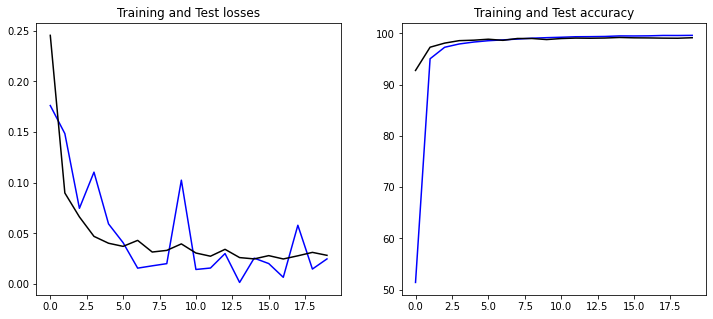

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

ax1.plot(train_losses, c='blue')
ax1.plot(test_losses, c='black')
ax1.title.set_text('Training and Test losses')

ax2.plot(train_acc, c='blue')
ax2.plot(test_acc, c='black')
ax2.title.set_text('Training and Test accuracy')